### Setup

In [1]:
#@title Installs

# You must ensure the that correct version for your environment is installed
!python -c "import torch; print(torch.__version__)"
!python --version

!pip -q install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
!pip -q install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
!pip -q install torch-geometric

2.0.0+cu118
Python 3.9.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.7/485.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [19]:
#@title Imports and Google Drive
import numpy as np
import pandas as pd
from math import sin, cos, pow
import random
from tqdm import tqdm
import time

import torch
from torch_geometric.data import Data, DataLoader

from os import listdir
from os.path import isfile, join

# Connecting to google drive - can remove if working locally
import os.path
from os import path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#@title Parameters
# path to the data
root_path = '/content/drive/MyDrive/Graph Data Mining/ADFA-LD/ADFA-LD-Dataset/ADFA-LD/'
normal_path = root_path + 'Training_Data_Master/'
validation_path = root_path + 'Validation_Data_Master/'
attack_path = root_path + 'Attack_Data_Master/'
# event embedding size
dimension = 4 
# number of possible events (number of syscalls)
num_events = 340
# dimension of the GNN's output
gnn_output_dimension = 3

In [6]:
#@title Data Preprocessing
def get_encoding(x, dim):
  result = []
  for j in range(dim):
    if j%2 == 0: # even
      r = sin(x/pow(10000, j/dim))
    else: # odd
      r = cos(x/pow(10000, (j-1)/dim))
    result.append(r)
  return result

def  gen_graphs(paths):
  graphs =[]
  seq = []
  times = []
  for x in tqdm(paths):
    file = open(x, 'r')
    s = [int(x) for x in file.readline().strip().split(" ")]
    start = time.perf_counter()
    if len(s) > 0:
      s_set = sorted(list(set(s)))
      # get node attributes
      attributes = []
      for n in range(1, num_events+1):
        attributes.append(get_encoding(n, dimension))
      a = torch.tensor(attributes, dtype=torch.float)
      # get edges between nodes
      edge_set = []
      edge_weights = []
      for x in range(len(s)-1):
          e = str(s_set.index(s[x]))+":"+str(s_set.index(s[x+1]))
          if e not in edge_set:
            edge_set.append(e)
            edge_weights.append(0)
          edge_weights[edge_set.index(e)] += 1
      e_to = []
      e_from = []
      e_attr = []
      for e in range(len(edge_set)):
        e_from.append(int(edge_set[e].split(":")[0]))
        e_to.append(int(edge_set[e].split(":")[1]))
        e_attr.append((edge_weights[e]/(len(s)-1)))
      edge_index = torch.tensor([e_from, e_to], dtype=torch.int)
      edge_attributes = torch.tensor(e_attr,dtype=torch.float)
      data = Data(x=a, edge_index=edge_index, edge_attr = edge_attributes)
      graphs.append(data)
      seq.append(s)
      times.append(time.perf_counter() - start)

  return graphs, seq, times

print("Normal Sequences:")
data_paths =  sorted([normal_path + f for f in listdir(normal_path) if isfile(join(normal_path, f))]) + [validation_path + f for f in listdir(validation_path) if isfile(join(validation_path, f))]
normal_graphs, normal_sequences, normal_times = gen_graphs(data_paths)

print("Attack Sequences:")
data_paths = []
for directory in listdir(attack_path):
  p = attack_path + directory
  data_paths = data_paths + [p +"/" + f for f in listdir(p) if isfile(join(p, f))]
attack_graphs, attack_seq, attack_times = gen_graphs(data_paths)

validation_graphs = normal_graphs[:len(attack_graphs)]
validation_seq = normal_sequences[:len(attack_graphs)]
graphs = normal_graphs[len(attack_graphs):]
sequences = normal_sequences[len(attack_graphs):]

print("\nNumber of training graphs: %d\nNumber of test graphs:\n\tAnomalous: %d\n\tNormal: %d" %(len(graphs), len(attack_graphs), len(validation_graphs)))

times = normal_times + attack_times
print("\nAverage graph generation time: %0.3f" % (sum(times)/len(times)))

Normal Sequences:


100%|██████████| 5205/5205 [00:27<00:00, 191.15it/s]


Attack Sequences:


100%|██████████| 746/746 [04:36<00:00,  2.70it/s]


Number of training graphs: 4459
Number of test graphs:
	Anomalous: 746
	Normal: 746

Average graph generation time: 0.003


Normal
Sequence:  [11, 192, 6, 125, 197, 54, 5, 6, 220, 220, 195, 5, 220, 195, 195, 195, 195, 195, 195, 195, 5, 220, 195, 220, 5, 195, 195, 4, 195, 5, 220, 195, 5, 4, 195, 4, 4, 197, 195, 4, 195, 4, 195, 220, 195, 195, 195, 195, 195, 195, 4, 195, 195, 220, 5, 195, 195, 195, 4, 195, 5, 220, 4, 4, 195, 195, 195, 4, 220, 197, 220, 195, 195, 195, 5, 220, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 4, 5, 4, 220, 195, 195, 6, 195, 195, 195, 5, 195, 195, 195, 5, 220, 6, 195, 195, 195, 195, 5, 220, 195, 195, 195, 195, 5, 195, 195, 195, 5, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 6, 5, 195, 4, 195, 195, 5, 195, 220, 195, 195, 220, 195, 195, 5, 5, 5, 220, 195, 195, 195, 195, 5, 220, 5, 197, 5, 220, 220, 220, 5, 5, 5, 5, 197, 5, 6, 5, 220, 220, 5, 220, 220, 45, 220, 6, 4, 4, 5, 197, 220, 220, 5, 220, 5, 220, 5, 220, 5, 5, 6, 5, 220, 220, 220, 5, 4, 220, 220, 4, 4, 5, 197, 5, 197, 220, 5, 5, 220, 220, 5, 4, 5, 6, 197, 5, 220, 5, 5, 5, 5, 6, 5, 4, 5, 220, 5, 5, 6, 5, 5, 5, 

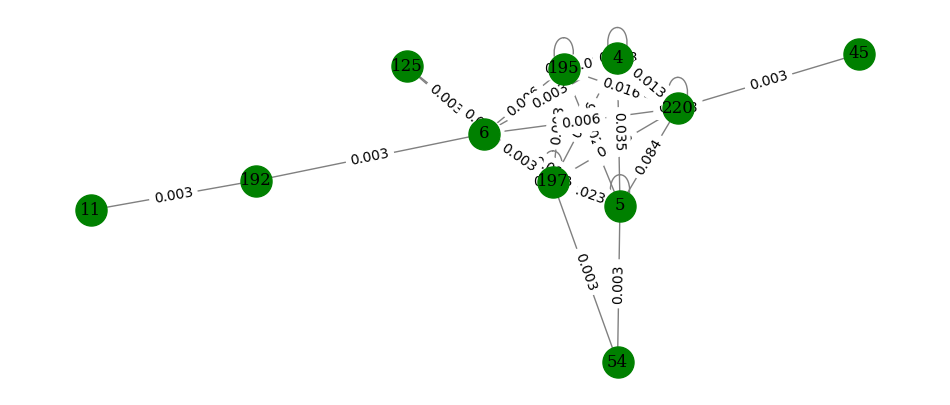

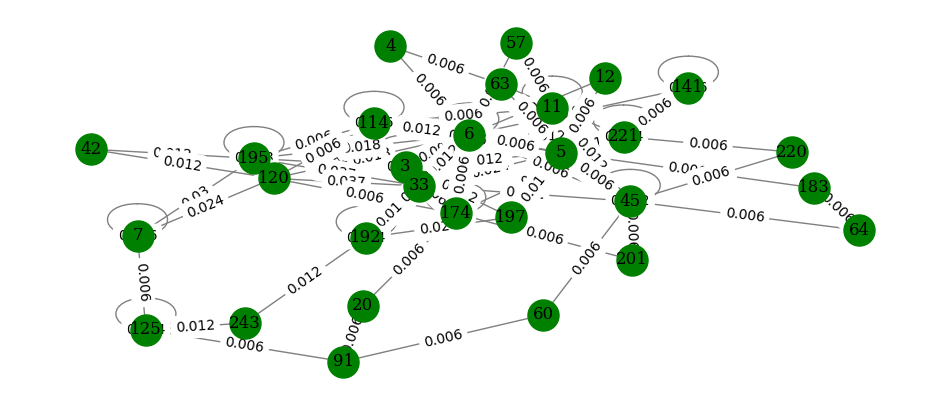

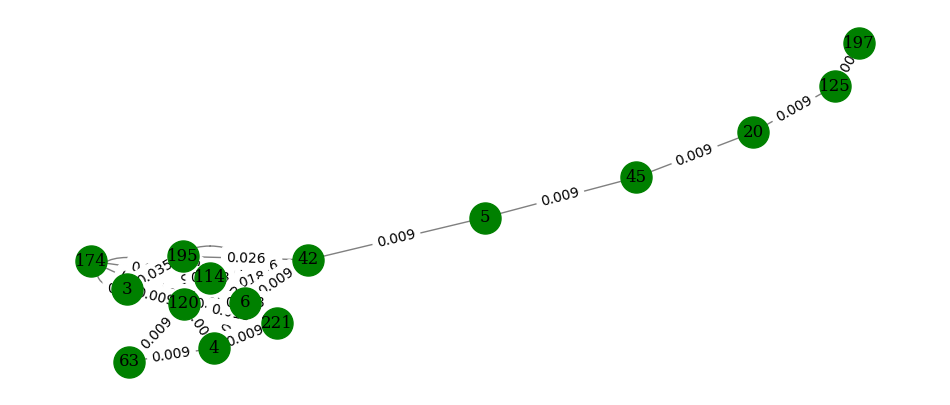

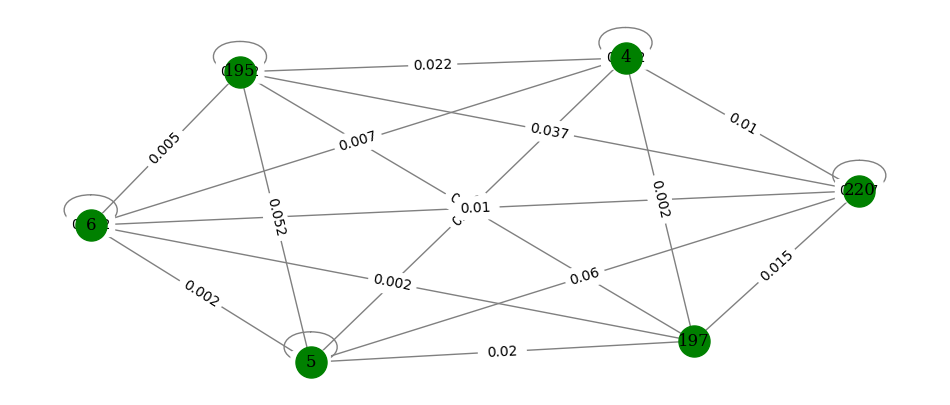

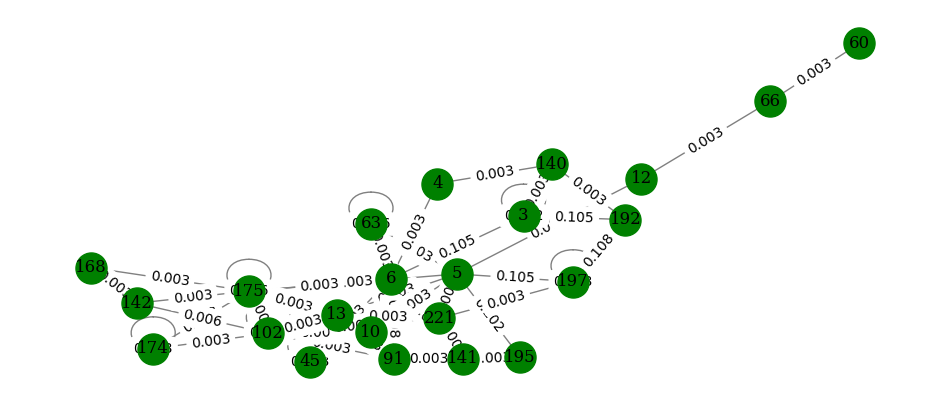

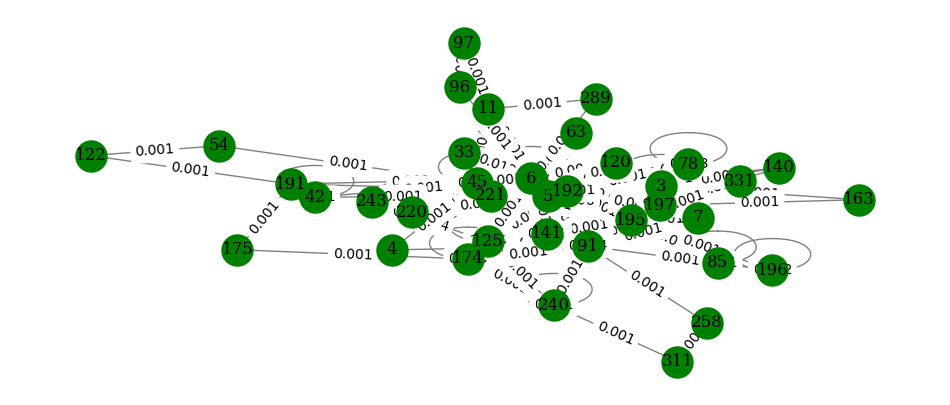

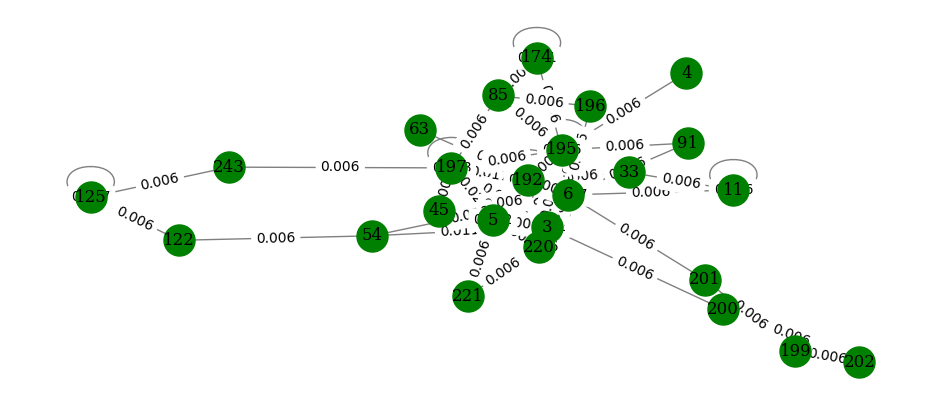

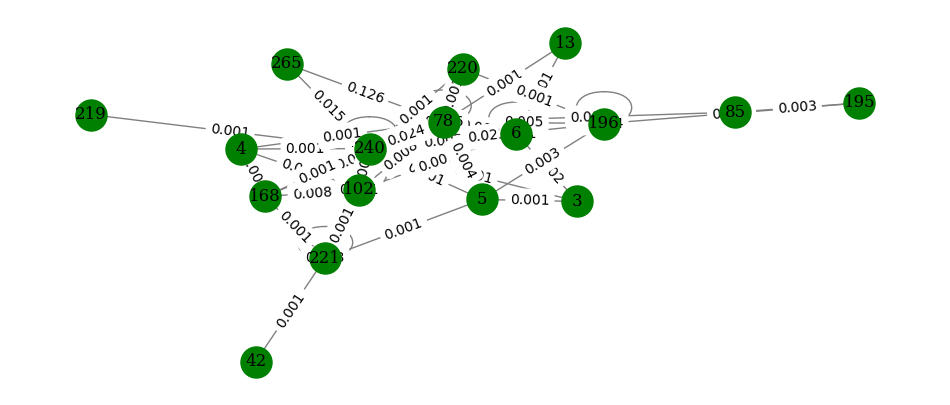

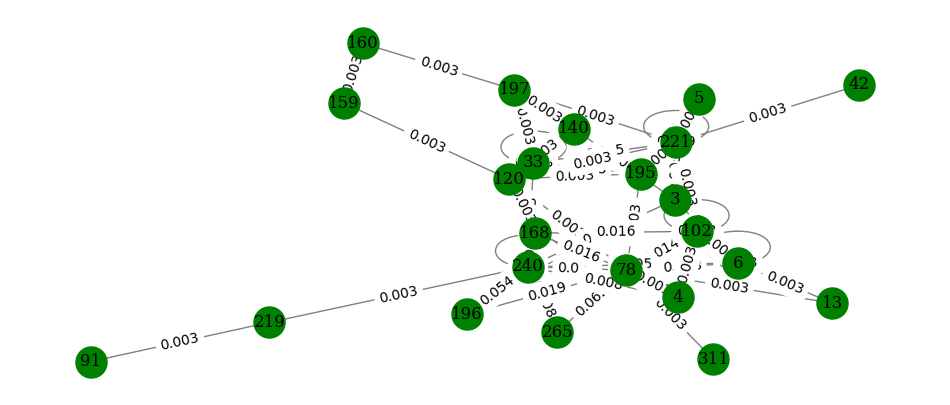

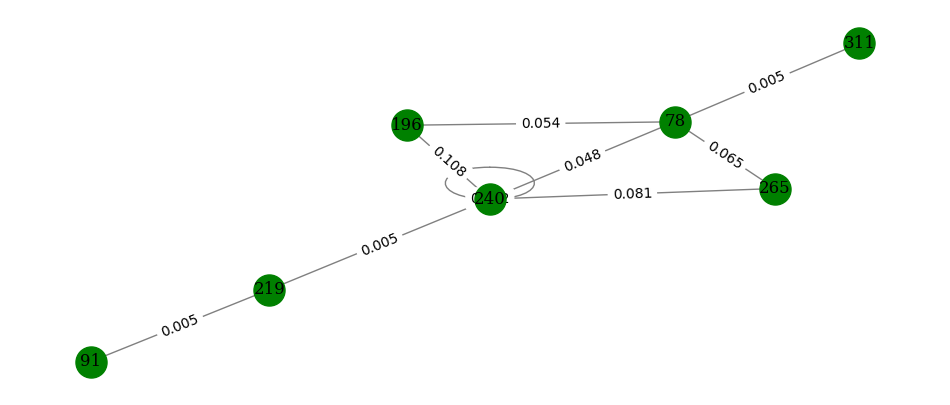

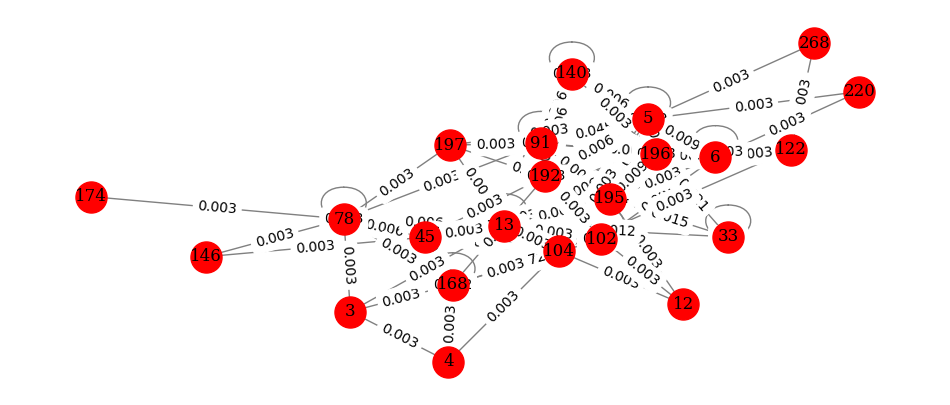

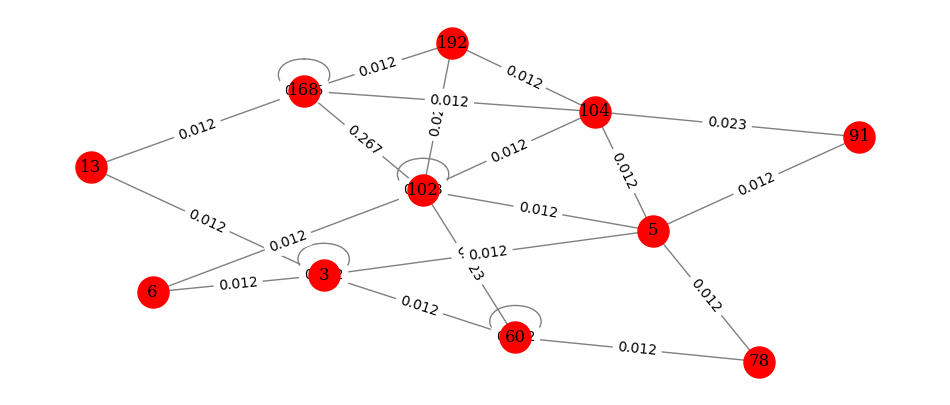

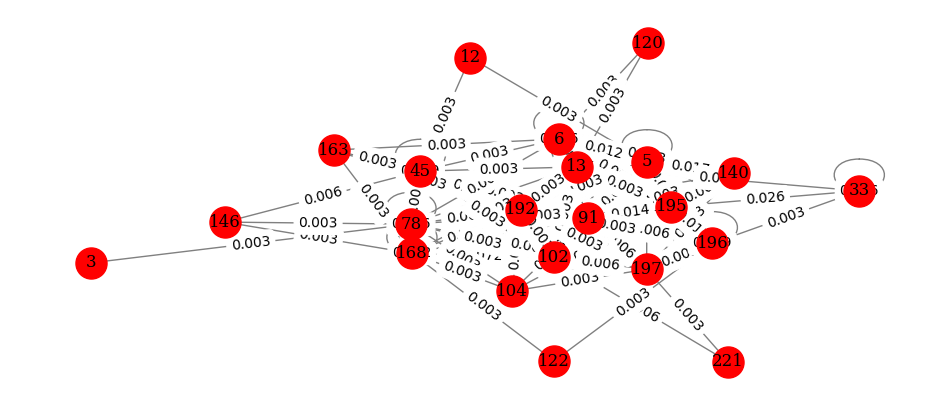

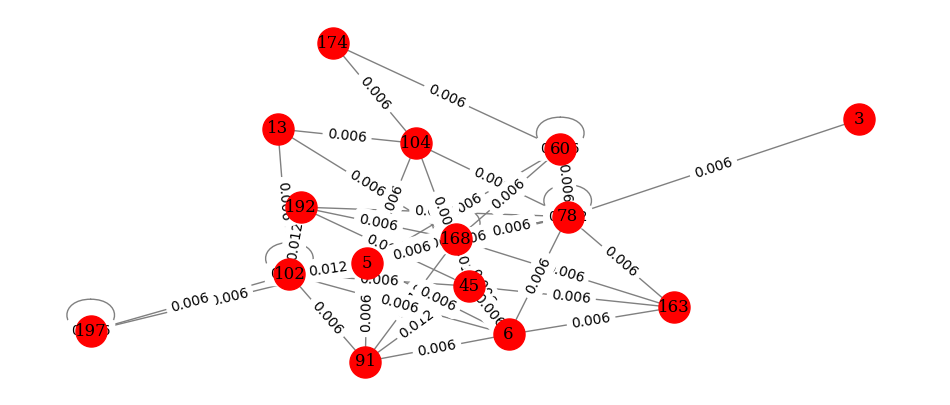

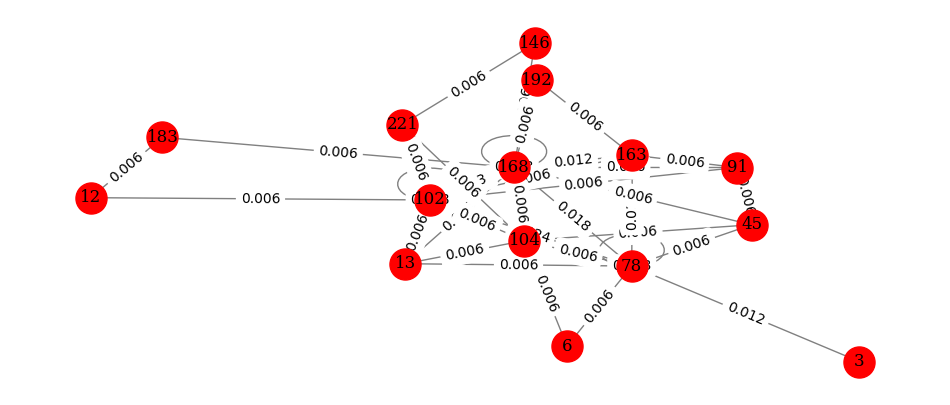

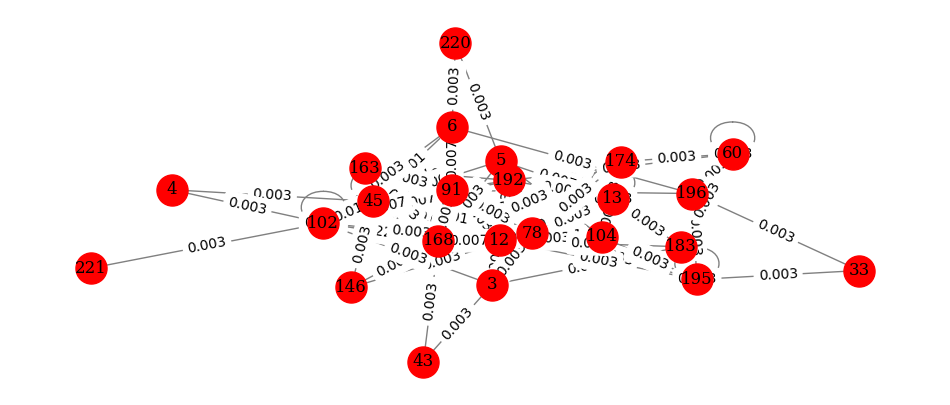

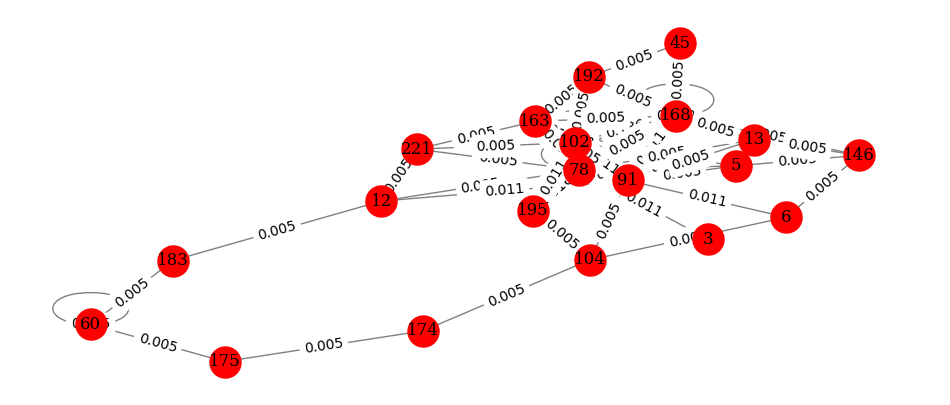

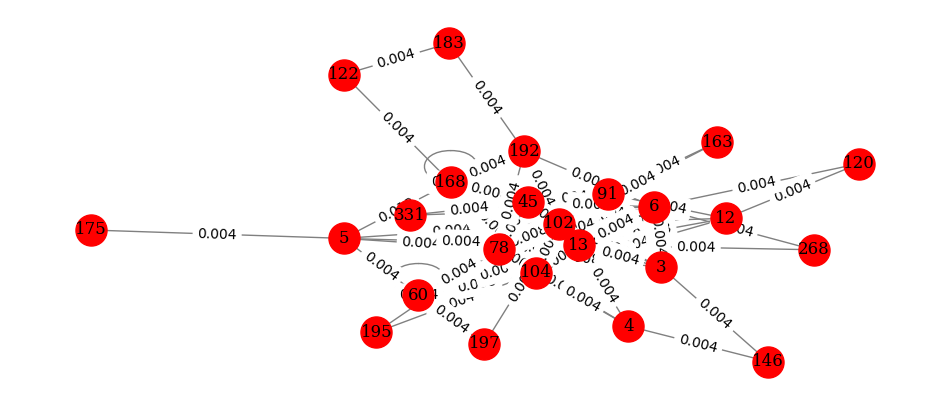

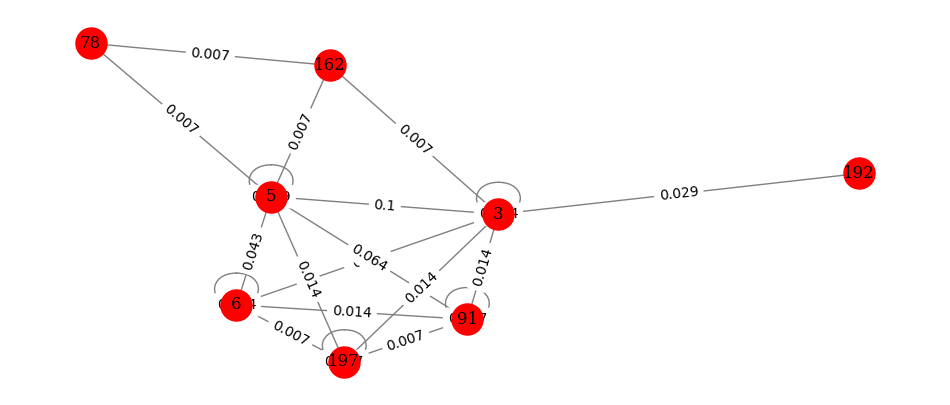

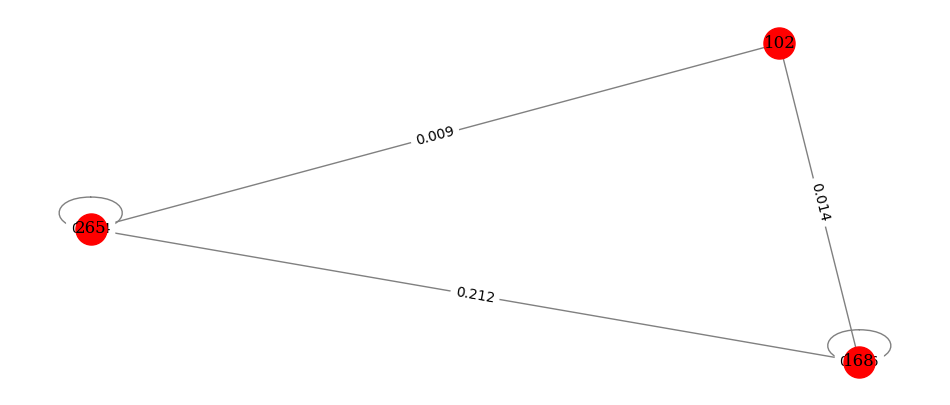

In [7]:
#@title Visualize First Graphs
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

def show_graph(ex, seq, colour = 'green'):
  print("Sequence: ", seq)
  s_set = sorted(list(set(seq)))
  G = nx.Graph()
  G.add_nodes_from(s_set)
  indices = ex.edge_index.tolist()
  edges = []
  edge_labels = {}
  e = ex.edge_attr.tolist()
  for i in range(len(indices[0])):
    G.add_edge(s_set[int(indices[0][i])], s_set[int(indices[1][i])])
    edge_labels[(s_set[int(indices[0][i])], s_set[int(indices[1][i])])] = round(e[i], 3)


  def draw(G):
      pos = nx.spring_layout(G, seed=0)
      fig, ax = plt.subplots(figsize=(12,5))
      nx.draw(
          G,  pos, with_labels = True,
          node_color=colour, 
          ax=ax, edge_color='gray', node_size=500, font_size=12, font_family='serif'
      )
      labels = nx.get_edge_attributes(G,'weight')
      nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

  draw(G)

  attr = ex.x.tolist()

print("Normal")
for x in range(10):
  show_graph(graphs[x], sequences[x], 'green')

print("Anomaly")
for x in range(10):
  show_graph(attack_graphs[x], attack_seq[x], 'red')

### Training Model

In [8]:
#@title Define GNN Model
import torch
from torch.nn import Linear
import torch.nn.functional as F
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class Embeddings(nn.Module):
  def __init__(self, hidden_channels=64):
    super(Embeddings, self).__init__()
    torch.manual_seed(200)
    self.conv1 = GCNConv(dimension, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, gnn_output_dimension)

  def forward(self, data):
    x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
    x = self.conv1(x, edge_index, edge_weight=edge_attr)
    x = x.relu()
    x = self.conv2(x, edge_index, edge_weight=edge_attr)
    x = x.relu()
    x = self.conv3(x, edge_index, edge_weight=edge_attr)

    x = global_mean_pool(x, batch=None)  

    return x.tolist()[0]

model = Embeddings()

In [15]:
#@title Get Embeddings
embeddings = []
times = []
print("Normal")
for x in tqdm(graphs):
  start = time.perf_counter()
  embeddings.append(model(x))
  times.append(time.perf_counter()-start)

attack_embeddings = []
print("Attack")
for x in tqdm(attack_graphs):
  start = time.perf_counter()
  attack_embeddings.append(model(x))
  times.append(time.perf_counter()-start)

val_embeddings = []
print("Validation")
for x in tqdm(validation_graphs):
  start = time.perf_counter()
  val_embeddings.append(model(x))
  times.append(time.perf_counter()-start)

print("\nAverage graph embedding time: %0.3f" % (sum(times)/len(times)))

Normal


100%|██████████| 4459/4459 [00:14<00:00, 306.57it/s]


Attack


100%|██████████| 746/746 [00:02<00:00, 372.66it/s]


Validation


100%|██████████| 746/746 [00:02<00:00, 341.94it/s]


Average graph embedding time: 0.003


In [27]:
#@title Train Anomaly Detection Model
from sklearn.svm import OneClassSVM
X = embeddings
start = time.perf_counter()
svm_model = OneClassSVM(gamma='auto').fit(X)
print("SVM Training Time: %0.3f" %(time.perf_counter()-start))

SVM Training Time: 0.560


In [23]:
#@title Evaluate Model
start = time.perf_counter()
v_pred = list(svm_model.predict(val_embeddings))
t = time.perf_counter() - start
TN = v_pred.count(1)
FP = v_pred.count(-1)
print("Number of validation vectors: %d \n\tCorrect: %d\n\tIncorrect: %d"%(len(val_embeddings), TN, FP))
start = time.perf_counter()
a_pred = list(svm_model.predict(attack_embeddings))
t += time.perf_counter() - start
FN = a_pred.count(1)
TP = a_pred.count(-1)
print("Number of attack vectors: %d \n\tCorrect: %d\n\tIncorrect:%d"%(len(attack_embeddings), TP, FN))

acc = (TN + TP)/(TN+TP+FN+FP)
print("Accuracy: %0.3f" %(acc*100))
prec = TP/(TP+FP)
print("Precision: %0.3f" %(prec*100))
recall = TP/(TP+FN)
print("Recall: %0.3f" %(recall*100))

print("\nAverage Anomaly Classification time: %0.4f" %(t/(len(val_embeddings) + len(attack_embeddings))))

Number of validation vectors: 746 
	Correct: 400
	Incorrect: 346
Number of attack vectors: 746 
	Correct: 547
	Incorrect:199
Accuracy: 63.472
Precision: 61.254
Recall: 73.324

Average Anomaly Classification time: 0.0005
